In [29]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 50

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 324447775.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4203181.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 145530310.10it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20729628.69it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
sample = next(iter(data))
print(sample[0].shape, sample[1].shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [7]:
def show_image(x, idx):
    x = x.view(-1, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

Class - 6


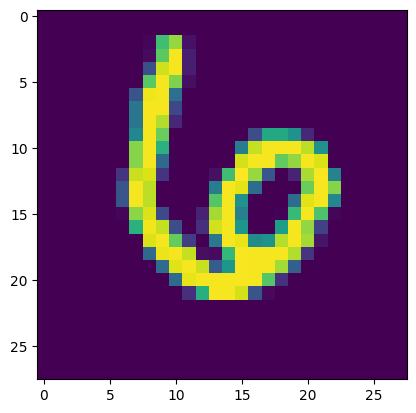

In [8]:
show_image(sample[0], idx=0)
print(f"Class - {sample[1][0]}")

### Автоэнкодер

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [12]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch - {epoch}")
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [13]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)
autoencoder = train(autoencoder, data)

Epoch - 0
Epoch - 1
Epoch - 2
Epoch - 3
Epoch - 4
Epoch - 5
Epoch - 6
Epoch - 7
Epoch - 8
Epoch - 9
Epoch - 10
Epoch - 11
Epoch - 12
Epoch - 13
Epoch - 14
Epoch - 15
Epoch - 16
Epoch - 17
Epoch - 18
Epoch - 19


In [14]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

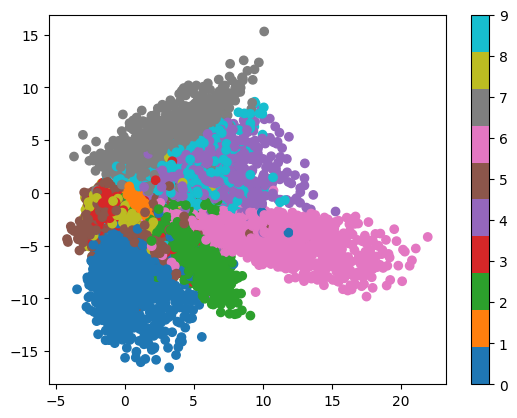

In [15]:
plot_latent(autoencoder, data)

In [16]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

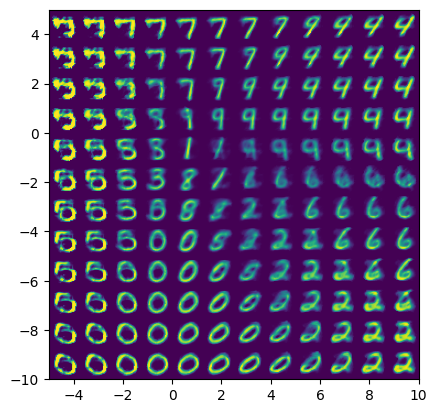

In [17]:
plot_reconstructed(autoencoder)

### Вариационный автоэнкодер

In [18]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [19]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [20]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch - {epoch}")
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [21]:
vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, data)

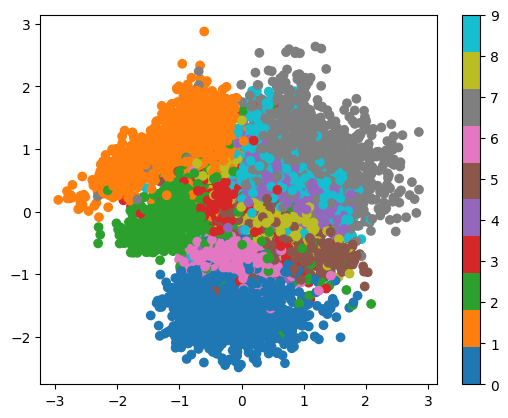

In [22]:
plot_latent(vae, data)

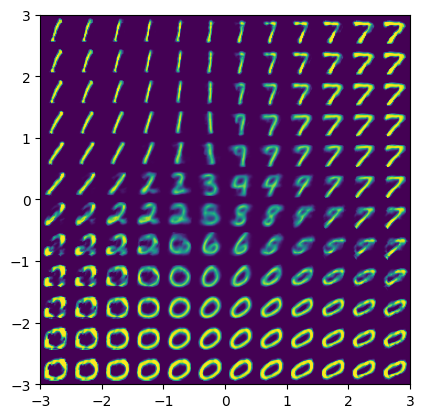

In [23]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

In [24]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [38]:
x, y = next(iter(data))
x_1 = x[y == 1][0].to(device)
x_0 = x[y == 0][0].to(device)

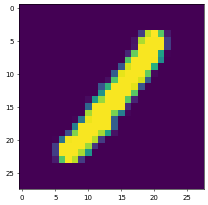

In [39]:
show_image(x_1, idx=0)

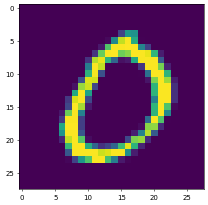

In [40]:
show_image(x_0, idx=0)

In [46]:
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

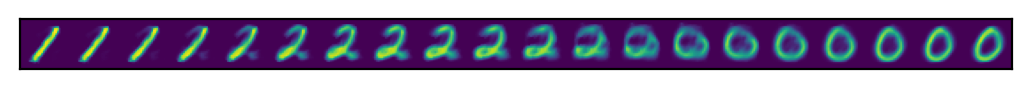

In [47]:
interpolate(vae, x_1, x_0, n=20)

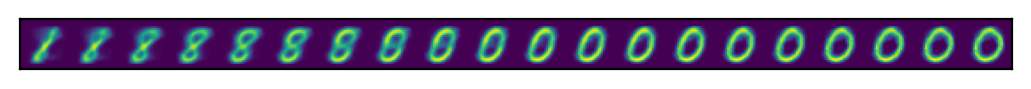

In [48]:
interpolate(autoencoder, x_1, x_0, n=20)

In [49]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1]
    
    images_list[0].save(
        f'{filename}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=1)

In [50]:
interpolate_gif(vae, "vae", x_1, x_0)

### Вариационный энкодер с условием

In [56]:
class CVariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(CVariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784 + 10, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x, label):
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((x, label), dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [62]:
class CVariationalDecoder(nn.Module):
    def __init__(self, latent_dims):
        super(CVariationalDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims + 10, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z, label):
        z = F.relu(self.linear1(torch.cat((z, label), dim=1)))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [63]:
class CVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(CVariationalAutoencoder, self).__init__()
        self.encoder = CVariationalEncoder(latent_dims)
        self.decoder = CVariationalDecoder(latent_dims)
    
    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z, y)

In [64]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch - {epoch}")
        for x, y in data:
            x = x.to(device)
            y = torch.nn.functional.one_hot(y, num_classes=10).to(device)
            opt.zero_grad()
            x_hat = autoencoder(x, y)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
cvae = CVariationalAutoencoder(latent_dims).to(device)
cvae = train(cvae, data)

In [66]:
def plot_latent_cvae(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device),
          torch.nn.functional.one_hot(y, num_classes=10).to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

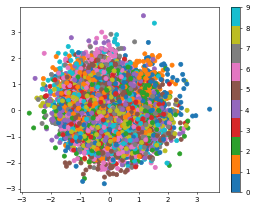

In [68]:
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 50
plot_latent_cvae(cvae, data)

In [73]:
def plot_reconstructed_cvae(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12,
                            label=torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z, label.to(device))
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

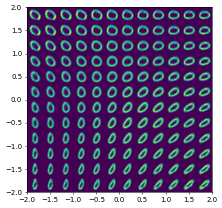

In [78]:
plot_reconstructed_cvae(cvae, r0=(-2, 2), r1=(-2, 2),
  label=torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

### Доп. материалы

**Вопрос:**

MSE или BCE в функции потерь?

- https://www.expunctis.com/2019/01/27/Loss-functions.html
- https://ai.stackexchange.com/questions/27341/in-variational-autoencoders-why-do-people-use-mse-for-the-loss
- https://arxiv.org/pdf/1312.6114.pdf#page=10
- https://github.com/pytorch/examples/issues/399

**Ссылки:**

[DeepMind x UCL | Deep Learning Lectures | 11/12 | Modern Latent Variable Models](https://www.youtube.com/watch?v=7Pcvdo4EJeo)

**Домашнее задание:**
Трансфер стиля (например - https://arxiv.org/pdf/2110.07375.pdf)
Запустите обучение на GPU/TPU c pytorch_xla и предоставьте сравнение (по времени) pytorch[gpu] / pytorch_xla[gpu] / pytorch_xla[tpu].


